In [2]:
from keras import optimizers, backend
from keras.layers import Activation, concatenate, Dense, Dropout, Embedding, Input, Reshape, Flatten
from keras.models import Model
from keras.utils import np_utils
from random import shuffle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE

from random import shuffle

import umap
pd.set_option('display.max_columns', 500)

%matplotlib inline 

Using TensorFlow backend.


In [3]:
data = pd.read_csv("combined_hockey2.csv")

In [4]:
data.columns

Index(['Unnamed: 0', 'Assist1', 'Assist1_ID', 'Assist2', 'Assist2_ID',
       'Assists2_ID', 'Away', 'Away_Score', 'EmptyNet', 'Event', 'EventID',
       'Event_Description', 'Event_Team', 'Event_Type_ID', 'Final_Away_Score',
       'Final_Home_Score', 'GameDate', 'GameID', 'GameState', 'GameType',
       'Goalie', 'Goalie_ID', 'Home', 'Home_Score', 'Period', 'Period_Type',
       'Player_1_ID', 'Player_1_Name', 'Player_2_ID', 'Player_2_Name',
       'Scorer', 'Scorer_ID', 'Shooter', 'Shooter_ID', 'ShotType',
       'Time_Remaining', 'Time_in_Period', 'Venue', 'x', 'y', 'Event2', 'Side',
       'Season', 'Attacking', 'y_stdz', 'x_stdz', 'y_normal', 'x_normal',
       'Event_Team_Adj', 'y_same', 'x_same', 'zone_x', 'zone_y', 'shot_zone',
       'Opposition Team'],
      dtype='object')

In [5]:
data = data[data['shot_zone'] != 'Other']

In [6]:
data = data[(data['Event'] == 'Shot') | (data['Event'] == 'Goal')]

In [7]:
data = data[data['Goalie'] != 'None']

In [8]:
events = data[['Shooter', 'Scorer', 'Goalie', 'ShotType', 'Event', 'shot_zone', 'Season']]

In [9]:
events['Shooter'] = events['Shooter'].str.replace('None', '') + events['Scorer'].str.replace('None', '')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
events.drop('Scorer', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [11]:
season_201718 = events[events['Season'] == '2017-2018'][['Shooter', 'Goalie', 'ShotType', 'Event', 'shot_zone']]

In [12]:
shooter_counts = season_201718['Shooter'].value_counts().reset_index()
shooters_to_keep = shooter_counts[shooter_counts['Shooter'] > 50]['index'].tolist()
goalie_counts = season_201718['Goalie'].value_counts().reset_index()
goalies_to_keep = goalie_counts[goalie_counts['Goalie'] > 100]['index'].tolist()

In [13]:
events_1718 = season_201718[(season_201718['Shooter'].isin(shooters_to_keep)) & 
                             (season_201718['Goalie'].isin(goalies_to_keep))]

In [14]:
events_1718['ShotType'].value_counts()

Wrist Shot     38380
Slap Shot      12348
Snap Shot      11163
Backhand        5797
Tip-In          3916
Deflected       1131
Wrap-around      483
None               1
Name: ShotType, dtype: int64

In [15]:
events_1718['shot_zone'].value_counts()

Right Net Front      9940
Center Net Front     9186
Left Net Front       9105
Center Blue Line     8185
Right Board          8149
Left Board           8078
Right Point          5797
Left Point           5758
Left Top Circle      3668
Right Top Circle     3334
Center Top Circle    2019
Name: shot_zone, dtype: int64

In [16]:
def shot_zone_group(x):
    if (x == 'Right Net Front') | (x == 'Center Net Front') | (x == 'Left Net Front'):
        return 'Net Front'
    elif (x == 'Left Top Circle') | (x == 'Right Top Circle') | (x == 'Center Top Circle'):
        return 'Top Circle'
    else:
        return x
    
events_1718['shot_zone2'] = events_1718['shot_zone'].apply(lambda x: shot_zone_group(x))    

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
events_1718['shot_zone2'].value_counts()

Net Front           28231
Top Circle           9021
Center Blue Line     8185
Right Board          8149
Left Board           8078
Right Point          5797
Left Point           5758
Name: shot_zone2, dtype: int64

In [18]:
#Let's Condense Shot Type
events_1718['ShotType'] = events_1718['ShotType'].apply(lambda x: 'TipIn_Deflected' 
                                                        if (x == 'Tip-In') | (x == 'Deflected') else x)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
events_1718['ShotType'].value_counts()

Wrist Shot         38380
Slap Shot          12348
Snap Shot          11163
Backhand            5797
TipIn_Deflected     5047
Wrap-around          483
None                   1
Name: ShotType, dtype: int64

In [20]:
events_1718 = events_1718[(events_1718['ShotType'] != 'Wrap-around') & (events_1718['ShotType'] != 'None')]

In [21]:
events_1718['ShotType'].value_counts()

Wrist Shot         38380
Slap Shot          12348
Snap Shot          11163
Backhand            5797
TipIn_Deflected     5047
Name: ShotType, dtype: int64

In [22]:
events_1718['Event'].value_counts()

Shot    65804
Goal     6931
Name: Event, dtype: int64

In [23]:
'''
How do we want to think about this? 

shooter + goalie + shot type = event + shot_zone? 
shooter + goalie = event + shot_zone + shot_type? 

'''

'\nHow do we want to think about this? \n\nshooter + goalie + shot type = event + shot_zone? \nshooter + goalie = event + shot_zone + shot_type? \n\n'

In [42]:
outcomes = events_1718[['Event', 'ShotType']].apply(lambda x: ' | '.join(x), axis=1)

In [43]:
goalies = events_1718['Goalie']
shooters = events_1718['Shooter']
zones = events_1718['shot_zone2']
#outcomes = events_1718['Event']

In [44]:
#Need Word to Int Dictionaries 
unique_outcomes = list(set([item for item in outcomes.values.tolist()]))
outcomes_to_int = {}
outcomes_to_int['values'] = {unique_outcomes[i]: i for i in range(len(unique_outcomes))}

In [45]:
#Need Word to Int Dictionaries 
unique_shooters = list(set([item for item in shooters.values.tolist()]))
shooters_to_int = {}
shooters_to_int['values'] = {unique_shooters[i]: i for i in range(len(unique_shooters))}

In [46]:
#Need Word to Int Dictionaries 
unique_goalies = list(set([item for item in goalies.values.tolist()]))
goalies_to_int = {}
goalies_to_int['values'] = {unique_goalies[i]: i for i in range(len(unique_goalies))}

In [47]:
#Need Word to Int Dictionaries 
unique_zones = list(set([item for item in zones.values.tolist()]))
zones_to_int = {}
zones_to_int['values'] = {unique_zones[i]: i for i in range(len(unique_zones))}

In [48]:
print("Unique Outcomes = " + str(len(unique_outcomes)))
print("Unique Shooters = " + str(len(unique_shooters)))
print("Unique Goalies = " + str(len(unique_goalies)))
print("Unique Shooting Zones = " + str(len(unique_zones)))

Unique Outcomes = 10
Unique Shooters = 553
Unique Goalies = 83
Unique Shooting Zones = 7


In [49]:
NUM_GOALIE_TYPES = len(goalies_to_int['values'])
NUM_SHOOTER_TYPES = len(shooters_to_int['values'])
NUM_OUTCOME_TYPES = len(outcomes_to_int['values'])
NUM_ZONE_TYPES = len(zones_to_int['values'])

In [50]:
def get_numeric(row, dictionary):
#     obs = []
#     for i in inputs.columns:
#         value = row[i]
#         value_index = category_to_int['values'][value]
#         obs.append(value_index)
#     return obs
        value_index = dictionary['values'][row]
        return value_index

In [51]:
outcomes = outcomes.apply(lambda row: get_numeric(row, outcomes_to_int)).values
goalies = goalies.apply(lambda row: get_numeric(row, goalies_to_int)).values
shooters = shooters.apply(lambda row: get_numeric(row, shooters_to_int)).values
zones = zones.apply(lambda row: get_numeric(row, zones_to_int)).values

In [53]:
GOALIE_VECSIZE = 10
SHOOTER_VECSIZE = 20
ZONE_VECSIZE = 7

ACTIVATION = "sigmoid"
goalie_idx = Input(shape = (1,), dtype = "int32", name="goalie_idx")
goalie_embed = Embedding(NUM_GOALIE_TYPES, GOALIE_VECSIZE, input_length = 1, name="goalie_embed0")(goalie_idx)
goalie_embed = Reshape((GOALIE_VECSIZE, ), name="goalie_embed1")(goalie_embed)
goalie_embed = Activation(ACTIVATION, name="goalie_embed2")(goalie_embed)

shooter_idx = Input(shape = (1,), dtype = "int32", name="shooter_idx")
shooter_embed = Embedding(NUM_SHOOTER_TYPES, SHOOTER_VECSIZE, input_length = 1, name="shooter_embed0")(shooter_idx)
shooter_embed = Reshape((SHOOTER_VECSIZE, ), name="shooter_embed1")(shooter_embed)
shooter_embed = Activation(ACTIVATION, name="shooter_embed2")(shooter_embed)

zone_idx = Input(shape = (1,), dtype = "int32", name="zone_idx")
zone_embed = Embedding(NUM_SHOOTER_TYPES, ZONE_VECSIZE, input_length = 1, name="zone_embed0")(zone_idx)
zone_embed = Reshape((ZONE_VECSIZE, ), name="zone_embed1")(zone_embed)
zone_embed = Activation(ACTIVATION, name="zone_embed2")(zone_embed)

goalie_shooter_zone = concatenate([goalie_embed, shooter_embed, zone_embed], name="goalie_shooter_zone")

output = Dense(units=NUM_OUTCOME_TYPES, activation= "softmax")(goalie_shooter_zone)

In [54]:
model = Model(inputs = [goalie_idx, shooter_idx, zone_idx], outputs = [output])
sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = "categorical_crossentropy")

In [55]:
BATCH_SIZE = 5000
NUM_EPOCHS = 1000
VALID = False
validation_split = 0.0
callbacks = None
if VALID:
    from keras.callbacks import ModelCheckpoint
    validation_split = 0.01
    callbacks = [ModelCheckpoint("weights.h5", save_best_only = True, save_weights_only = True)]

X_list = [goalies, shooters, zones]
y =  np_utils.to_categorical(np.array(outcomes), NUM_OUTCOME_TYPES)
history = model.fit(X_list, y, epochs = NUM_EPOCHS, batch_size = BATCH_SIZE,
                    verbose = 2, shuffle = True, callbacks = callbacks, validation_split = validation_split)
if not VALID:
    model.save_weights("weights.h5")

model.load_weights("weights.h5")
if VALID:
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc = "upper right")
    plt.show()

Epoch 1/1000
 - 0s - loss: 2.0488
Epoch 2/1000
 - 0s - loss: 1.6832
Epoch 3/1000
 - 0s - loss: 1.6360
Epoch 4/1000
 - 0s - loss: 1.6271
Epoch 5/1000
 - 0s - loss: 1.6245
Epoch 6/1000
 - 0s - loss: 1.6236
Epoch 7/1000
 - 0s - loss: 1.6231
Epoch 8/1000
 - 0s - loss: 1.6227
Epoch 9/1000
 - 0s - loss: 1.6225
Epoch 10/1000
 - 0s - loss: 1.6223
Epoch 11/1000
 - 0s - loss: 1.6220
Epoch 12/1000
 - 0s - loss: 1.6218
Epoch 13/1000
 - 0s - loss: 1.6216
Epoch 14/1000
 - 0s - loss: 1.6213
Epoch 15/1000
 - 0s - loss: 1.6211
Epoch 16/1000
 - 0s - loss: 1.6209
Epoch 17/1000
 - 0s - loss: 1.6207
Epoch 18/1000
 - 0s - loss: 1.6204
Epoch 19/1000
 - 0s - loss: 1.6201
Epoch 20/1000
 - 0s - loss: 1.6199
Epoch 21/1000
 - 0s - loss: 1.6196
Epoch 22/1000
 - 0s - loss: 1.6193
Epoch 23/1000
 - 0s - loss: 1.6190
Epoch 24/1000
 - 0s - loss: 1.6187
Epoch 25/1000
 - 0s - loss: 1.6184
Epoch 26/1000
 - 0s - loss: 1.6181
Epoch 27/1000
 - 0s - loss: 1.6177
Epoch 28/1000
 - 0s - loss: 1.6174
Epoch 29/1000
 - 0s - loss: 1

Epoch 232/1000
 - 0s - loss: 1.4551
Epoch 233/1000
 - 0s - loss: 1.4550
Epoch 234/1000
 - 0s - loss: 1.4549
Epoch 235/1000
 - 0s - loss: 1.4548
Epoch 236/1000
 - 0s - loss: 1.4548
Epoch 237/1000
 - 0s - loss: 1.4547
Epoch 238/1000
 - 0s - loss: 1.4546
Epoch 239/1000
 - 0s - loss: 1.4545
Epoch 240/1000
 - 0s - loss: 1.4545
Epoch 241/1000
 - 0s - loss: 1.4544
Epoch 242/1000
 - 0s - loss: 1.4543
Epoch 243/1000
 - 0s - loss: 1.4543
Epoch 244/1000
 - 0s - loss: 1.4542
Epoch 245/1000
 - 0s - loss: 1.4541
Epoch 246/1000
 - 0s - loss: 1.4541
Epoch 247/1000
 - 0s - loss: 1.4540
Epoch 248/1000
 - 0s - loss: 1.4539
Epoch 249/1000
 - 0s - loss: 1.4539
Epoch 250/1000
 - 0s - loss: 1.4538
Epoch 251/1000
 - 0s - loss: 1.4537
Epoch 252/1000
 - 0s - loss: 1.4537
Epoch 253/1000
 - 0s - loss: 1.4536
Epoch 254/1000
 - 0s - loss: 1.4536
Epoch 255/1000
 - 0s - loss: 1.4535
Epoch 256/1000
 - 0s - loss: 1.4534
Epoch 257/1000
 - 0s - loss: 1.4534
Epoch 258/1000
 - 0s - loss: 1.4533
Epoch 259/1000
 - 0s - loss:

Epoch 460/1000
 - 0s - loss: 1.4419
Epoch 461/1000
 - 0s - loss: 1.4418
Epoch 462/1000
 - 0s - loss: 1.4418
Epoch 463/1000
 - 0s - loss: 1.4417
Epoch 464/1000
 - 0s - loss: 1.4417
Epoch 465/1000
 - 0s - loss: 1.4416
Epoch 466/1000
 - 0s - loss: 1.4415
Epoch 467/1000
 - 0s - loss: 1.4415
Epoch 468/1000
 - 0s - loss: 1.4414
Epoch 469/1000
 - 0s - loss: 1.4414
Epoch 470/1000
 - 0s - loss: 1.4413
Epoch 471/1000
 - 0s - loss: 1.4413
Epoch 472/1000
 - 0s - loss: 1.4412
Epoch 473/1000
 - 0s - loss: 1.4412
Epoch 474/1000
 - 0s - loss: 1.4411
Epoch 475/1000
 - 0s - loss: 1.4410
Epoch 476/1000
 - 0s - loss: 1.4410
Epoch 477/1000
 - 0s - loss: 1.4409
Epoch 478/1000
 - 0s - loss: 1.4409
Epoch 479/1000
 - 0s - loss: 1.4408
Epoch 480/1000
 - 0s - loss: 1.4407
Epoch 481/1000
 - 0s - loss: 1.4407
Epoch 482/1000
 - 0s - loss: 1.4406
Epoch 483/1000
 - 0s - loss: 1.4406
Epoch 484/1000
 - 0s - loss: 1.4405
Epoch 485/1000
 - 0s - loss: 1.4405
Epoch 486/1000
 - 0s - loss: 1.4404
Epoch 487/1000
 - 0s - loss:

Epoch 688/1000
 - 0s - loss: 1.4304
Epoch 689/1000
 - 0s - loss: 1.4304
Epoch 690/1000
 - 0s - loss: 1.4303
Epoch 691/1000
 - 0s - loss: 1.4303
Epoch 692/1000
 - 0s - loss: 1.4303
Epoch 693/1000
 - 0s - loss: 1.4302
Epoch 694/1000
 - 0s - loss: 1.4302
Epoch 695/1000
 - 0s - loss: 1.4301
Epoch 696/1000
 - 0s - loss: 1.4301
Epoch 697/1000
 - 0s - loss: 1.4301
Epoch 698/1000
 - 0s - loss: 1.4300
Epoch 699/1000
 - 0s - loss: 1.4300
Epoch 700/1000
 - 0s - loss: 1.4299
Epoch 701/1000
 - 0s - loss: 1.4299
Epoch 702/1000
 - 0s - loss: 1.4299
Epoch 703/1000
 - 0s - loss: 1.4298
Epoch 704/1000
 - 0s - loss: 1.4298
Epoch 705/1000
 - 0s - loss: 1.4297
Epoch 706/1000
 - 0s - loss: 1.4297
Epoch 707/1000
 - 0s - loss: 1.4297
Epoch 708/1000
 - 0s - loss: 1.4296
Epoch 709/1000
 - 0s - loss: 1.4296
Epoch 710/1000
 - 0s - loss: 1.4295
Epoch 711/1000
 - 0s - loss: 1.4295
Epoch 712/1000
 - 0s - loss: 1.4295
Epoch 713/1000
 - 0s - loss: 1.4294
Epoch 714/1000
 - 0s - loss: 1.4294
Epoch 715/1000
 - 0s - loss:

Epoch 916/1000
 - 0s - loss: 1.4220
Epoch 917/1000
 - 0s - loss: 1.4220
Epoch 918/1000
 - 0s - loss: 1.4220
Epoch 919/1000
 - 0s - loss: 1.4219
Epoch 920/1000
 - 0s - loss: 1.4219
Epoch 921/1000
 - 0s - loss: 1.4219
Epoch 922/1000
 - 0s - loss: 1.4218
Epoch 923/1000
 - 0s - loss: 1.4218
Epoch 924/1000
 - 0s - loss: 1.4218
Epoch 925/1000
 - 0s - loss: 1.4217
Epoch 926/1000
 - 0s - loss: 1.4217
Epoch 927/1000
 - 0s - loss: 1.4217
Epoch 928/1000
 - 0s - loss: 1.4216
Epoch 929/1000
 - 0s - loss: 1.4216
Epoch 930/1000
 - 0s - loss: 1.4215
Epoch 931/1000
 - 0s - loss: 1.4215
Epoch 932/1000
 - 0s - loss: 1.4215
Epoch 933/1000
 - 0s - loss: 1.4214
Epoch 934/1000
 - 0s - loss: 1.4214
Epoch 935/1000
 - 0s - loss: 1.4214
Epoch 936/1000
 - 0s - loss: 1.4213
Epoch 937/1000
 - 0s - loss: 1.4213
Epoch 938/1000
 - 0s - loss: 1.4213
Epoch 939/1000
 - 0s - loss: 1.4212
Epoch 940/1000
 - 0s - loss: 1.4212
Epoch 941/1000
 - 0s - loss: 1.4212
Epoch 942/1000
 - 0s - loss: 1.4211
Epoch 943/1000
 - 0s - loss:

In [56]:
from keras import backend
get_goalies_vec = backend.function([goalie_idx], [goalie_embed])
get_shooters_vec = backend.function([shooter_idx], [shooter_embed])

In [57]:
goalies_vecs = get_goalies_vec([np.array(range(NUM_GOALIE_TYPES)).reshape((NUM_GOALIE_TYPES, 1))])[0]
shooters_vecs = get_shooters_vec([np.array(range(NUM_SHOOTER_TYPES)).reshape((NUM_SHOOTER_TYPES, 1))])[0]

In [58]:
goalies_nums = np.array(range(NUM_GOALIE_TYPES))
int_to_goalies = {v: k for k, v in goalies_to_int['values'].items()}
goalies_values = []
for i in goalies_nums:
    goalies_values.append(int_to_goalies[i])

shooters_nums = np.array(range(NUM_SHOOTER_TYPES))
int_to_shooters = {v: k for k, v in shooters_to_int['values'].items()}
shooters_values = []
for i in shooters_nums:
    shooters_values.append(int_to_shooters[i])

outcome_nums = np.array(range(NUM_OUTCOME_TYPES))
int_to_outcome = {v: k for k, v in outcomes_to_int['values'].items()}
outcome_values = []
for i in outcome_nums:
    outcome_values.append(int_to_outcome[i])

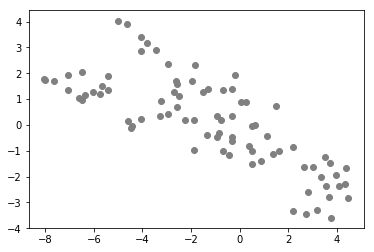

In [59]:
tsne = TSNE(n_components = 2)
condensed = tsne.fit_transform(goalies_vecs)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(condensed[:, 0], condensed[:, 1], color = "gray")

plt.show()

In [60]:
goalies = pd.DataFrame({'Goalie': goalies_values, 'TSNE1': condensed[:, 0], 'TSNE2': condensed[:, 1]})
goalies[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']] = pd.DataFrame(goalies_vecs)

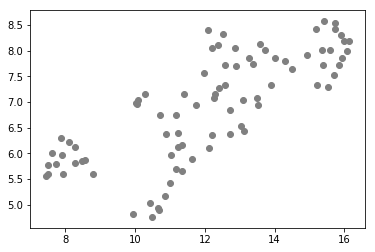

In [61]:
embedding = umap.UMAP().fit_transform(goalies_vecs)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(embedding[:, 0], embedding[:, 1], color = "gray")

plt.show()

In [62]:
goalies['UMAP1'] = embedding[:, 0]
goalies['UMAP2'] = embedding[:, 1]

In [63]:
players_20172018 = pd.read_csv("player_vitals_20172018.csv")

In [64]:
goalies = goalies.merge(players_20172018, left_on='Goalie', right_on='Name', how='left')

In [65]:
goalies.to_csv("20172018_goalies.csv", index=False)

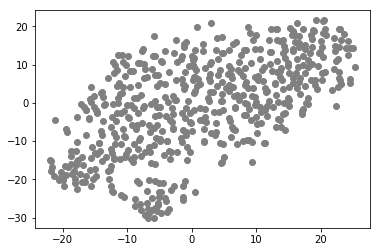

In [66]:
tsne = TSNE(n_components = 2)
condensed = tsne.fit_transform(shooters_vecs)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(condensed[:, 0], condensed[:, 1], color = "gray")

plt.show()

In [67]:
shooters = pd.DataFrame({'Shooter': shooters_values, 'TSNE1': condensed[:, 0], 'TSNE2': condensed[:, 1]})
shooters[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']] = pd.DataFrame(shooters_vecs)

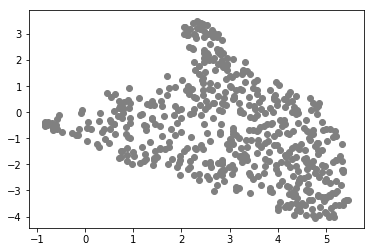

In [68]:
embedding = umap.UMAP().fit_transform(shooters_vecs)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(embedding[:, 0], embedding[:, 1], color = "gray")

plt.show()

In [69]:
shooters['UMAP1'] = embedding[:, 0]
shooters['UMAP2'] = embedding[:, 1]

In [70]:
players_20172018 = pd.read_csv("player_vitals_20172018.csv")

In [ ]:
players_20172018.head()

In [71]:
shooters = shooters.merge(players_20172018, left_on='Shooter', right_on='Name', how='left')

In [72]:
shooter_stats = pd.read_csv("player_stats_20172018_shooters.csv")

In [73]:
shooter_stats

,timeOnIce,assists,goals,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,PlayerID,Player_1_ID_x,Player_1_Name_x,Player_1_ID_y,Player_1_Name_y
0,125:41,3.0,0.0,29.0,13.0,17.0,30.0,0.0,0.0,02:47,122:54,29.0,33.33,0.0,0.0,0.0,0.0,0.0,00:00,5.0,2.0,3.0,188.0,07:23,07:13,00:00,00:09,8478421,8478421,A.J. Greer,8478421,A.J. Greer
1,1522:05,NaN,NaN,NaN,NaN,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52:29,NaN,NaN,NaN,8477180,8477180,Aaron Dell,8477180,Aaron Dell
2,1917:54,22.0,16.0,71.0,189.0,82.0,69.0,5.0,11.0,174:23,1559:42,71.0,0.00,8.5,4.0,1.0,0.0,0.0,183:49,121.0,9.0,38.0,2376.0,23:23,19:01,02:14,02:07,8477932,8477932,Aaron Ekblad,8477932,Aaron Ekblad
3,101:49,1.0,0.0,8.0,2.0,8.0,1.0,0.0,0.0,00:00,95:00,8.0,0.00,0.0,0.0,0.0,0.0,0.0,06:49,8.0,2.0,1.0,155.0,12:43,11:52,00:51,00:00,8474604,8474604,Aaron Ness,8474604,Aaron Ness
4,79:40,2.0,0.0,2.0,4.0,5.0,2.0,0.0,0.0,01:44,77:17,2.0,0.00,0.0,0.0,0.0,0.0,0.0,00:39,6.0,-1.0,2.0,107.0,15:56,15:27,00:07,00:20,8476431,8476431,Adam Clendening,8476431,Adam Clendening
5,38:33,0.0,0.0,0.0,6.0,5.0,12.0,0.0,0.0,00:00,33:50,0.0,50.00,0.0,0.0,0.0,0.0,0.0,04:43,1.0,-1.0,0.0,66.0,07:42,06:46,00:56,00:00,8471490,8471490,Adam Cracknell,8471490,Adam Cracknell
6,232:44,1.0,3.0,11.0,29.0,23.0,37.0,0.0,0.0,01:46,230:34,11.0,62.50,10.3,1.0,0.0,0.0,0.0,00:24,8.0,-1.0,4.0,335.0,10:07,10:01,00:01,00:04,8477454,8477454,Adam Erne,8477454,Adam Erne
7,63:56,0.0,0.0,0.0,9.0,5.0,2.0,0.0,0.0,03:44,60:12,0.0,37.50,0.0,0.0,0.0,0.0,0.0,00:00,3.0,2.0,0.0,90.0,12:47,12:02,00:00,00:44,8478874,8478874,Adam Gaudette,8478874,Adam Gaudette
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8478194,8478194,Adam Helewka,8478194,Adam Helewka
9,1440:36,26.0,24.0,20.0,151.0,81.0,61.0,6.0,13.0,204:55,1107:45,20.0,48.15,15.9,8.0,1.0,1.0,3.0,127:56,61.0,11.0,50.0,1844.0,17:47,13:40,01:34,02:31,8474641,8474641,Adam Henrique,8474641,Adam Henrique


In [74]:
shooters = shooters.merge(shooter_stats, left_on='Shooter', right_on='Player_1_Name_x', how='left')

In [75]:
shooters.to_csv("20172018_shooters.csv", index=False)

In [76]:
shooters.head()

,Shooter,TSNE1,TSNE2,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,UMAP1,UMAP2,Name,PrimaryNumber,BirthDate,BirthCity,BirthState,BirthCountry,Nationality,Height,Weight,Active,AlternateCaptain,Captain,Rookie,Shoots_Catches,RosterStatus,CurrentTeam,Position,Season,timeOnIce,assists,goals,pim,shots,games,hits,powerPlayGoals,powerPlayPoints,powerPlayTimeOnIce,evenTimeOnIce,penaltyMinutes,faceOffPct,shotPct,gameWinningGoals,overTimeGoals,shortHandedGoals,shortHandedPoints,shortHandedTimeOnIce,blocked,plusMinus,points,shifts,timeOnIcePerGame,evenTimeOnIcePerGame,shortHandedTimeOnIcePerGame,powerPlayTimeOnIcePerGame,PlayerID,Player_1_ID_x,Player_1_Name_x,Player_1_ID_y,Player_1_Name_y
0,John Carlson,-5.255939,-26.249367,0.496715,0.521710,0.516044,0.479562,0.512791,0.523662,0.515622,0.537280,0.513767,0.526565,0.476361,0.495330,0.482094,0.502117,0.494939,0.512882,0.482804,0.526918,0.488401,0.502003,-0.478944,-0.747450,John Carlson,74.0,1990-01-10,Natick,MA,USA,USA,"6' 3""",218.0,True,False,False,False,R,Y,Washington Capitals,D,2017-2018,2032:06,53.0,15.0,32.0,237.0,82.0,47.0,4.0,32.0,303:43,1512:54,32.0,0.00,6.3,4.0,1.0,0.0,0.0,215:29,146.0,0.0,68.0,2164.0,24:46,18:27,02:37,03:42,8474590,8474590,John Carlson,8474590,John Carlson
1,Bobby Ryan,6.618655,-1.286118,0.511086,0.494390,0.497008,0.500020,0.504293,0.501863,0.493120,0.488531,0.495497,0.497117,0.516153,0.495661,0.491202,0.508221,0.497915,0.486753,0.495414,0.501763,0.511520,0.504998,4.142945,-0.465142,Bobby Ryan,9.0,1987-03-17,Cherry Hill,NJ,USA,USA,"6' 2""",209.0,True,False,False,False,R,Y,Ottawa Senators,RW,2017-2018,1019:23,22.0,11.0,14.0,112.0,62.0,97.0,1.0,4.0,167:54,850:59,14.0,54.54,9.8,1.0,0.0,0.0,0.0,00:30,52.0,-12.0,33.0,1301.0,16:26,13:43,00:00,02:42,8471676,8471676,Bobby Ryan,8471676,Bobby Ryan
2,Austin Watson,9.831142,14.157305,0.492983,0.480175,0.496255,0.505745,0.515780,0.489943,0.504209,0.498104,0.510841,0.504534,0.496857,0.505357,0.524875,0.503618,0.497928,0.507013,0.498356,0.492853,0.485144,0.501907,2.582142,-2.563453,Austin Watson,51.0,1992-01-13,Ann Arbor,MI,USA,USA,"6' 4""",204.0,True,False,False,False,R,Y,Nashville Predators,LW,2017-2018,937:12,5.0,14.0,123.0,96.0,76.0,187.0,0.0,0.0,02:14,766:03,123.0,62.79,14.6,3.0,0.0,4.0,5.0,168:55,78.0,2.0,19.0,1373.0,12:19,10:04,02:13,00:01,8475766,8475766,Austin Watson,8475766,Austin Watson
3,Kyle Brodziak,12.245898,13.406156,0.496324,0.497978,0.503278,0.517804,0.512053,0.494358,0.515960,0.500686,0.505310,0.503962,0.500688,0.508518,0.507139,0.519680,0.500668,0.507493,0.511081,0.494853,0.488773,0.502820,4.275809,-3.526903,Kyle Brodziak,28.0,1984-05-25,St. Paul,AB,CAN,CAN,"6' 2""",205.0,True,False,False,False,R,Y,Edmonton Oilers,C,2017-2018,1090:29,23.0,10.0,33.0,113.0,81.0,83.0,0.0,0.0,05:59,942:33,33.0,52.12,8.8,2.0,0.0,1.0,3.0,141:57,55.0,13.0,33.0,1610.0,13:27,11:38,01:45,00:04,8470803,8470803,Kyle Brodziak,8470803,Kyle Brodziak
4,Leo Komarov,-17.699051,-14.899088,0.482199,0.501250,0.504797,0.488502,0.491554,0.492433,0.497286,0.505385,0.491862,0.473807,0.498411,0.481530,0.481243,0.477615,0.499702,0.481270,0.488180,0.474685,0.512043,0.499945,2.712216,2.954699,Leo Komarov,47.0,1987-01-23,Narva,NaN,EST,FIN,"5' 11""",209.0,True,False,False,False,L,Y,New York Islanders,RW,2017-2018,1168:14,12.0,7.0,31.0,114.0,74.0,219.0,2.0,3.0,51:41,925:43,31.0,52.83,6.1,0.0,0.0,1.0,1.0,190:50,48.0,0.0,19.0,1691.0,15:47,12:30,02:34,00:41,8473463,8473463,Leo Komarov,8473463,Leo Komarov
